#  IE 582 Statistical Learning for Data Mining - Homework 2

# Mine Gazioğlu

In [75]:
# Importing necessary libraries

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np # linear algebra
import matplotlib.pyplot as plt # visualization
import seaborn as sns # visualization
import warnings # ignore deprecation warnings etc.
warnings.filterwarnings("ignore")
from sklearn.decomposition import PCA # to perform PCA
from sklearn.manifold import MDS # to perform multidimensional scaling
from sklearn.preprocessing import StandardScaler # for scaling our data
from sklearn import preprocessing # change raw feature vectors into a representation that is more suitable for the downstream estimators
from plotnine import * # generates the graph R's ggplot2 in Python
from PIL import Image # to read images
from matplotlib.pyplot import imshow # to display images
import cv2 # Read images
import imageio # Read images

In [76]:
# Load data with pandas
# Since our data has no column names use header = None
musk = pd.read_csv("582\HW2\Musk1.csv", header = None)

In [77]:
# Rename columns
# First 2 columns are bag class and bag id 
musk.rename(columns = {0:"bag_class",1:"bag_id"},inplace = True)
# The rest of the columns follow the format feature + "i" where i denotes numbers from 1-167
musk.columns.values[2:] = ["feature_"+ str(i) for i in range(1,167,1)]

In [78]:
# Let's take a look at first 5 rows of our data
display(musk.head())

,bag_class,bag_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166
0,1,1,42,-198,-109,-75,-117,11,23,-88,...,-238,-74,-129,-120,-38,30,48,-37,6,30
1,1,1,42,-191,-142,-65,-117,55,49,-170,...,-238,-302,60,-120,-39,31,48,-37,5,30
2,1,1,42,-191,-142,-75,-117,11,49,-161,...,-238,-73,-127,-120,-38,30,48,-37,5,31
3,1,1,42,-198,-110,-65,-117,55,23,-95,...,-238,-302,60,-120,-39,30,48,-37,6,30
4,1,2,42,-198,-102,-75,-117,10,24,-87,...,-238,-73,-127,51,128,144,43,-30,14,26


We have **92** molecules (each molecule denoted with bag_id) <br> of which **47** are judged by human
experts to be **musks(represented with class 1)** <br>and the remaining **45** molecules are judged to be **non-musks(represented with class 0)**

# Task 1: Multiple Instance Learning

**What we want to accomplish in Task 1/a:**

**a)** <br>1. Use PCA and MDS to understand the structure of the data. 
<br>  2. Report relevant measures
<br>  3. Comment on how good is the assumption of the instance labels’ being as the same as bag labels.
<br> 4. You can plot reduced dimensions on a figure in which instances are color-coded with their bag
labels.
***

**PCA**

PCA includes 5  steps :

Prepare the data :<br>
**1.**<br>
>**a) Center the data :** subtract the mean from each variables. This produces a data set whose mean is zero.<br>
 **b) Scale the data :** If the variances of the variables in your data are significantly different, it’s a good idea to 
 scale the data to unit variance. This is achieved by dividing each variables by its standard deviation.<br>
 

**2. Calculate the covariance/correlation matrix**(use the covariance matrix when the variable are on similar scales and the correlation matrix when the scales of the variables differ)<br>
**3. Calculate the eigenvectors and the eigenvalues of the covariance matrix**<br>
**4. Choose principal components :** eigenvectors are ordered by eigenvalues from the highest to the lowest. The number of chosen eigenvectors will be the number of dimensions of the new data set. eigenvectors = (eig_1, eig_2,…, eig_n)<br>
**5. compute the new dataset :**<br>
>**a) transpose eigeinvectors :** rows are eigenvectors<br>
**b) transpose the adjusted data** (rows are variables and columns are individuals)<br>
**c) new.data** = eigenvectors.transposed X adjustedData.transposed

We will use **sklearn.decomposition.PCA** to perform PCA. In [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) it is stated that:<br> 
> "The input data is centered but not scaled for each feature before applying the SVD".

PCA is affected by scale so, we need to scale our data before performing PCA

In [79]:
# Standardize the dataset’s features into unit scale (mean = 0 and variance = 1) using StandardScaler

standard = StandardScaler()
# separating our dataset into features and a target column(X,y)
X = (musk.drop(["bag_class","bag_id"], axis = 1))
# apply StandardScaler and transform X
X = standard.fit_transform(X)
# X into a dataframe
X = pd.DataFrame(X)
# define target variable y
y = (musk["bag_id"])

**How many principal components should we choose ?**

Is reducing to **2D** good enough? Let's find out

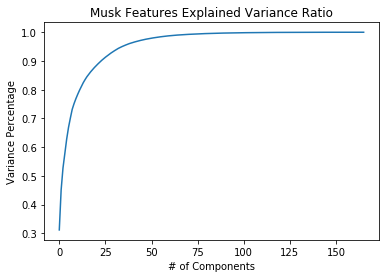

In [80]:
pca = PCA().fit(X)
#Plotting the Cumulative Summation of the Explained Variance Ratio
# This helps us see how much of the total variance is covered with each principal component cumulatively
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# of Components')
plt.ylabel('Variance Percentage') #for each component
plt.title('Musk Features Explained Variance Ratio')
plt.show()

Total variance is the sum of variances of all individual principal components.<br>

Explained variance ratio is the division between variance of the principal component and total variance

From the plot if we were to select 25 components we would preserve ~85% of the total variance. However, we can't visualize 25D. We will keep first 2 components instead.

In [81]:
pca = PCA(n_components = 2) # n_components specifies the new dimensionality
# Fit and transform PCA algorithm with features
X_reduced = pca.fit_transform(X)
# After dimensionality reduction we have 2 new components that are the two main dimensions of variation : (PC1,PC2)
X_reduced = pd.DataFrame( data = X_reduced, columns = ["PC1","PC2"])

Let's perform a Scree Plot of the first 2 Principal Components

A scree plot helps to visualize the percentage of variation captured by each of the principal components

Text(0.5, 1.0, 'PCA Scree Plot')

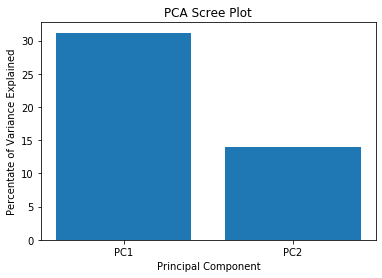

In [82]:
# Draw a scree plot
# Percentage variance gives the variance covered by each component out of the total variance
percentage_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = X_reduced.columns
plt.bar(x= range(1,3), height=percentage_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained')
plt.xlabel('Principal Component')
plt.title('PCA Scree Plot')


In [83]:
print('Explained Variance Ratio Total:', str(round(sum(pca.explained_variance_ratio_)*100,2)) + "%")

Explained Variance Ratio Total: 45.11%


First 2 components account for 45.07% of the total variation

In [84]:
# Percentage variances for the first 2 components
print(percentage_variance)

[31.19 13.92]


First component constitutes %31.19 of the total variance.<br> Second component constitutes %13.92 of the total variance.

In [85]:
# The set of first 2 eigenvectors for the projection space(we set n_components = 2 and we kept the first 2 components)
print('Components:', pca.components_)

Components: [[ 3.68698531e-02  6.83111424e-02  9.48053725e-02 -9.25859839e-02
   9.00473084e-04  6.09551501e-02 -1.25062362e-01  5.58131913e-03
  -1.24083914e-01  8.62403142e-02 -3.71693280e-02 -5.76714000e-02
   8.57068196e-04 -2.02699252e-03 -6.02295444e-03  5.84143220e-03
  -1.22013120e-01 -6.91416790e-03 -4.83480633e-02  3.07739083e-02
  -9.54809181e-02 -1.26712611e-01 -1.17147875e-01  1.15541364e-01
   1.21644756e-01 -1.18388035e-01 -9.07931865e-02 -7.32678677e-02
  -5.77062987e-02  1.23635183e-01  1.81526293e-02  1.07793223e-02
  -8.45717016e-02  1.13458177e-01 -1.10275730e-01  5.32722990e-02
  -3.45904361e-02 -9.89882830e-02  9.32206484e-02 -8.62779151e-02
   8.99903712e-02  1.96823063e-02  4.01366499e-02 -2.16287911e-02
  -2.49877139e-02 -3.05508969e-02 -1.71025631e-02 -1.00801521e-01
  -8.30083401e-03  7.50975451e-02 -7.18098225e-02 -1.26625307e-01
  -1.25194714e-01 -3.97046134e-02  8.82637054e-02 -7.06470907e-02
  -1.23431331e-01  2.42818647e-02  1.52772575e-03  1.15603400e-0

In [86]:
# Concatenate bag_id and reduced features so that we can visualize our PCA plot colored by bag_id
musk_df = pd.concat([X_reduced,(musk["bag_id"])],axis = 1)
# Concatenate bag class for visualization purposes
musk_df = pd.concat([musk_df,(musk["bag_class"])],axis = 1)

In [87]:
musk_df.head()

,PC1,PC2,bag_id,bag_class
0,0.787850,8.664480,1,1
1,0.782505,8.544104,1,1
2,0.248081,8.360294,1,1
3,1.356422,9.106098,1,1
4,1.459051,8.685006,2,1


**Visualizing 2D Projection**

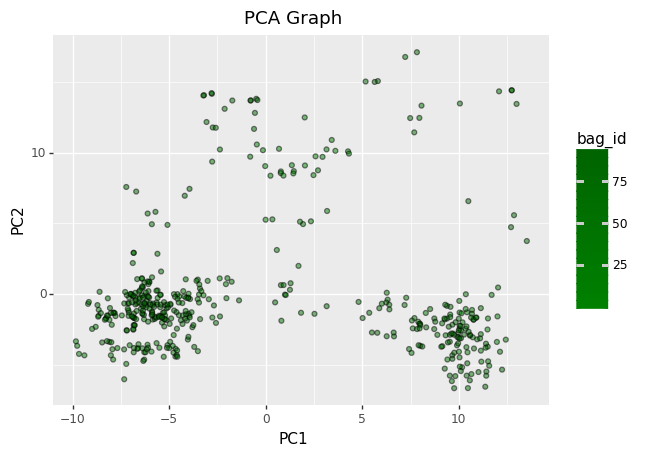

<ggplot: (-9223371939546747792)>

In [88]:
from plotnine import * # this package generates the graph R's ggplot2 in Python

# PCA Plot
ggplot(
    musk_df) + geom_point(aes(x = 'PC1',y = 'PC2',fill = 'bag_id'),alpha = 0.5) +labs(
        title ='PCA Graph',
        x = 'PC1',
        y = 'PC2',) +scale_fill_gradient(low="green",high="darkgreen") 

In PCA plot cells that are highly correlated cluster together. Here we see 2 clusters that denote 2 bag classes musk(1) and non-musk(0). We see some scattered values that are positioned away from the clusters as well. PCA does not perform well when there are nonlinear relationships within the data. Sparse data might be the result of this. After bag_id 47 the class changes. We see that clusters are distinct in shade of green instances that they contain. Left cluster contains mostly darker instances which we would expect to represent class 0 and the other cluster to represent class 1.

**MDS**

PCA and MDS are very similar. <br> - PCA creates plots based on correlations among samples and <br> - MDS creates plots based on distances among samples (**If we use Euclidean metric to calculate distance then PCA and MDS are the same!**)
>as a result the closer the samples are to one another the more tightly they cluster

In [89]:
# Standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) using StandardScaler

standard = StandardScaler()
# separating our dataset into features and a target column(X,y)
X = (musk.drop(["bag_class","bag_id"], axis = 1))
# apply StandardScaler to X
X = standard.fit_transform(X)
# turn X into a dataframe
X = pd.DataFrame(X)
# define target variable y
y = (musk["bag_id"])

In [90]:
# MDS
mds = MDS(n_components=2,random_state = 42)
# Transform data with MDS
X_transformed = mds.fit_transform(X)

In [91]:
# Convert to dataframe 
X_transformed = pd.DataFrame(X_transformed, columns = ["MDS1","MDS2"])

In [92]:
# Concat bag_id with thee dataframe
musk_df_2 = pd.concat([X_transformed,musk["bag_id"]],axis = 1)

In [93]:
# Musk_df_2 dataframe
musk_df_2.head()

,MDS1,MDS2,bag_id
0,-11.125510,-6.784717,1
1,7.626452,9.656401,1
2,-10.294480,-6.990444,1
3,-11.753350,-6.528793,1
4,7.057856,9.786580,2


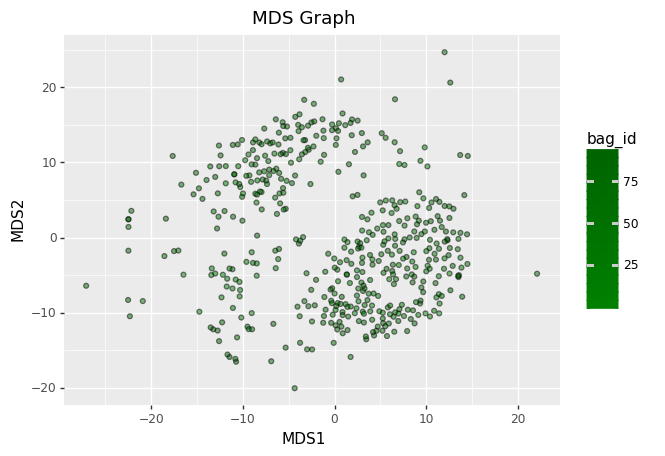

<ggplot: (-9223371939546722108)>

In [94]:
# MDS plot

ggplot(
    musk_df_2) + geom_point(aes(x = 'MDS1',y = 'MDS2',fill = 'bag_id'),alpha = 0.5) +labs(
        title ='MDS Graph',
        x = 'MDS1',
        y = 'MDS2',)+scale_fill_gradient(low="green",high="darkgreen") 

In MDS plot cells close in distance cluster together. Here we see 2 clusters that denote 2 bag classes musk(1) and non-musk(0). We see that clusters are distinct in shade of green instances that they contain. Upper left cluster contains mostly darker instances which we would expect to represent class 0 and the other cluster to represent class 1. However the distribution of the instances by color does not seem very distinguishable. Also, we expect class 1 to have more instances although the difference is very small(47-45) we might consider the cluster below to be class 0. Overall, the graph the does not give a clear insight to interpret. PCA graph was easier to comment on.

**b)** One easy way to represent the bag is to take the average of the instance
features so that the bag is represented by the center of its instances. 
>Use PCA and MDS to see if this is a good
transformation approach for classifying bags.

**PCA**-mean

Let's do all steps above but for each bag let's take the average of the instances

Taking averages of instances for each bag id should describe central tendency of the instances for a bag id

In [95]:
# Let's reread the dataframe for a clean start
# Load data with pandas
# Since our data has no column names use header = None
musk_2 = pd.read_csv("582\HW2\Musk1.csv", header = None)
# Rename columns
# First 2 columns are bag class and bag id 
musk_2.rename(columns = {0:"bag_class",1:"bag_id"},inplace = True)
# The rest of the columns follow the format feature + "i" where i denotes numbers from 1-167
musk_2.columns.values[2:] = ["feature_"+ str(i) for i in range(1,167,1)]

In [96]:
# Groupby musk dataframe by bag_id then take average of feature columns 
musk_2 = musk_2.groupby("bag_id").apply(np.mean)

In [97]:
musk_2.head()

,bag_class,bag_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166
bag_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,42.000000,-194.500000,-125.750000,-70.000000,-117.0,33.000000,36.000000,-128.5,...,-238.000000,-187.75,-34.0,-120.000000,-38.500000,30.250000,48.000000,-37.000000,5.500000,30.250000
2,1.0,2.0,42.000000,-194.500000,-122.000000,-70.000000,-117.0,33.000000,36.250000,-128.0,...,-238.000000,-186.25,-32.5,51.000000,126.500000,143.500000,42.750000,-30.250000,14.000000,26.500000
3,1.0,3.0,42.000000,-166.000000,-102.500000,-30.500000,-116.5,5.000000,27.500000,-142.5,...,-235.500000,-57.50,-45.5,13.000000,120.500000,133.500000,55.500000,-32.500000,2.000000,16.500000
4,1.0,4.0,42.666667,-154.666667,-77.333333,-42.333333,-117.0,22.333333,21.666667,-132.0,...,-237.333333,-142.00,-15.0,-80.333333,-33.666667,31.333333,50.333333,-38.333333,5.333333,32.333333
5,1.0,5.0,61.500000,-72.500000,-102.000000,-25.250000,-34.0,19.000000,29.000000,-143.5,...,-237.750000,-117.25,-60.5,5.000000,75.750000,136.750000,68.500000,-26.750000,-0.250000,36.750000


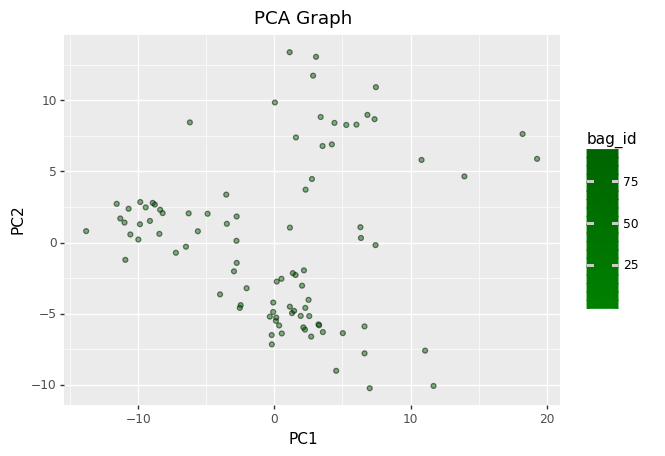

<ggplot: (-9223371939546673480)>

In [98]:
# Standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) using StandardScaler

standard = StandardScaler()
# separating our dataset into features and a target column(X,y)
X = (musk_2.drop(["bag_class","bag_id"], axis = 1))
# apply StandardScaler to X
X = standard.fit_transform(X)
# turn X into a dataframe
X = pd.DataFrame(X)
# define target variable y
y = (musk_2["bag_id"])

# PCA

pca = PCA(n_components = 2) # n_components specifies the new dimensionality
# Fit and transform PCA algorithm with features
X_reduced = pca.fit_transform(X)
# After dimensionality reduction we have 2 new components that are the two main dimensions of variation.(PC1,PC2)
X_reduced = pd.DataFrame( data = X_reduced, columns = ["PC1","PC2"])

# Concatenate bag_id and reduced features so that we can visualize our PCA plot colored by bag_id
musk_df_3 = pd.concat([X_reduced,(musk_2["bag_id"])],axis = 1)


# Plotting with ggplot

ggplot(
    musk_df_3) + geom_point(aes(x = 'PC1',y = 'PC2',fill = 'bag_id'),alpha = 0.5) +labs(
        title ='PCA Graph',
        x = 'PC1',
        y = 'PC2',) +scale_fill_gradient(low="green",high="darkgreen") 


We see 2 slight clusters which are reduced in size as we have reduced all instances 2 one row by taking average. There are still non-clustered sparse data point. Before taking average clusters were more prominent and more distinguishable by their bag_ids. 

**MDS**-mean

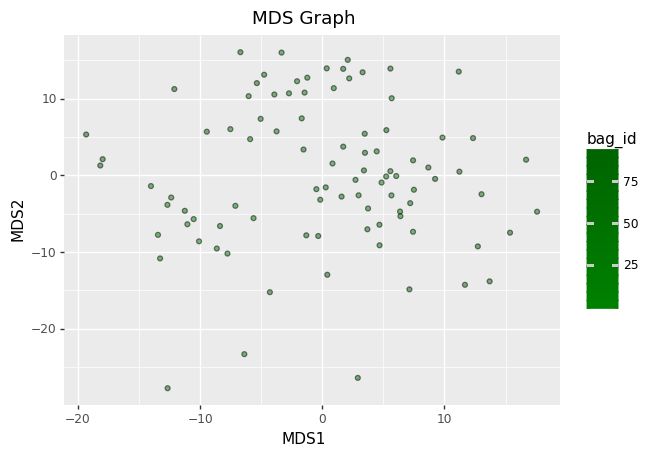

<ggplot: (-9223371939546639340)>

In [99]:
# Let's reread the dataframe for a clean start
# Load data with pandas
# Since our data has no column names use header = None
musk_3 = pd.read_csv("582\HW2\Musk1.csv", header = None)
# Rename columns
# First 2 columns are bag class and bag id 
musk_3.rename(columns = {0:"bag_class",1:"bag_id"},inplace = True)
# The rest of the columns follow the format feature + "i" where i denotes numbers from 1-167
musk_3.columns.values[2:] = ["feature_"+ str(i) for i in range(1,167,1)]

# Groupby musk dataframe by bag_id then take average of feature columns 
musk_3 = musk_3.groupby("bag_id").apply(np.mean)

# Standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) using StandardScaler

standard = StandardScaler()
# separating our dataset into features and a target column(X,y)
X = (musk_3.drop(["bag_class","bag_id"], axis = 1))
# apply StandardScaler to X
X = standard.fit_transform(X)
# turn X into a dataframe
X = pd.DataFrame(X)
# define target variable y
y = (musk_3["bag_id"])

mds = MDS(n_components=2,random_state = 42)
X_transformed = mds.fit_transform(X)

X_transformed = pd.DataFrame(X_transformed, columns = ["MDS1","MDS2"])
musk_df_4 = pd.concat([X_transformed,musk_3["bag_id"]],axis = 1)


# MDS plot

ggplot(
    musk_df_4) + geom_point(aes(x = 'MDS1',y = 'MDS2',fill = 'bag_id'),alpha = 0.5) +labs(
        title ='MDS Graph',
        x = 'MDS1',
        y = 'MDS2',) +scale_fill_gradient(low="green",high="darkgreen") 


There are no clusters unlike the previous graph using MDS. Taking averages do not work with MDS.

**c) Can you think of any other way to represent each bag with a vector? In other words,
can you summarize a bag into a single feature vector (of size r where r can be any positive
number) using the instance-based information (4 instance of size p as in Figure 1 below)?**

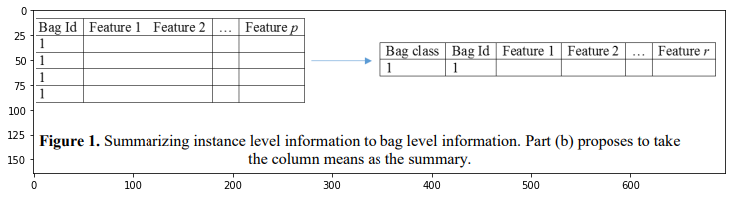

In [100]:
from PIL import Image #PIL provides general image handling
from pylab import *
figure_1 = Image.open("582\\HW2\\Figure_1.png")
plt.figure(figsize = (20,3))
plt.imshow(figure_1)

Median can be used as an alternative to mean as both are a measure of central tendency.

In [101]:
# To accomplish this let's reread our original musk dataframe as for the former one we have taken averages by bag id

musk_4 = pd.read_csv("582\HW2\Musk1.csv", header = None)

# Rename columns
musk_4.rename(columns = {0:"bag_class",1:"bag_id"},inplace = True)
musk_4.columns.values[2:] = ["feature_"+ str(i) for i in range(1,167,1)]

In [102]:
musk_4.head(6)

,bag_class,bag_id,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166
0,1,1,42,-198,-109,-75,-117,11,23,-88,...,-238,-74,-129,-120,-38,30,48,-37,6,30
1,1,1,42,-191,-142,-65,-117,55,49,-170,...,-238,-302,60,-120,-39,31,48,-37,5,30
2,1,1,42,-191,-142,-75,-117,11,49,-161,...,-238,-73,-127,-120,-38,30,48,-37,5,31
3,1,1,42,-198,-110,-65,-117,55,23,-95,...,-238,-302,60,-120,-39,30,48,-37,6,30
4,1,2,42,-198,-102,-75,-117,10,24,-87,...,-238,-73,-127,51,128,144,43,-30,14,26
5,1,2,42,-191,-142,-65,-117,55,49,-170,...,-238,-300,61,51,127,143,42,-31,14,26


In [103]:
# Median-- computation of np.mean with a groupby is very tricky so we use quantile(0.5 ,instead)
musk_4 = musk_4.groupby("bag_id").quantile(0.5).reset_index()

In [104]:
musk_4.head(10)

,bag_id,bag_class,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166
0,1,1.0,42.0,-194.5,-126.0,-70.0,-117.0,33.0,36.0,-128.0,...,-238.0,-188.0,-33.5,-120.0,-38.5,30.0,48.0,-37.0,5.5,30.0
1,2,1.0,42.0,-194.5,-122.0,-70.0,-117.0,33.5,36.5,-127.5,...,-238.0,-186.5,-32.0,51.0,127.0,143.5,42.5,-30.0,14.0,26.0
2,3,1.0,42.0,-166.0,-102.5,-30.5,-116.5,5.0,27.5,-142.5,...,-235.5,-57.5,-45.5,13.0,120.5,133.5,55.5,-32.5,2.0,16.5
3,4,1.0,42.0,-170.0,-63.0,-65.0,-117.0,15.0,24.0,-136.0,...,-237.0,-78.0,23.0,-67.0,-32.0,31.0,49.0,-38.0,7.0,32.0
4,5,1.0,60.0,-94.0,-102.0,-30.5,-116.5,14.5,30.5,-143.5,...,-237.0,-69.5,-67.0,17.0,87.0,160.0,59.0,-30.5,-2.5,29.0
5,6,1.0,46.5,-148.0,-104.0,-39.5,-117.0,-36.0,44.0,-183.0,...,-240.0,-181.0,-72.0,15.5,75.5,128.5,61.5,-28.0,8.0,41.5
6,7,1.0,47.5,-148.5,-101.0,-22.5,-117.0,-2.5,54.0,-65.0,...,-241.0,-174.5,-12.0,14.5,71.5,126.0,63.0,-28.0,6.5,41.5
7,8,1.0,41.5,-195.0,-155.5,-74.5,-117.0,-22.0,38.0,-27.5,...,-238.5,-91.0,28.0,50.5,126.5,142.5,43.0,-29.5,14.5,26.0
8,9,1.0,43.0,-168.0,-145.0,28.0,-117.0,-87.0,42.0,42.0,...,-236.0,-250.0,-207.0,21.0,54.0,118.0,78.0,-28.0,3.0,72.0
9,10,1.0,44.0,-155.0,-84.0,-24.0,-117.0,-59.5,-57.5,49.5,...,-236.5,-187.0,-83.5,-73.0,-31.0,29.5,51.0,-39.0,3.0,31.0


Let's apply PCA and MDS to see how this approach will work out compared to the former one

PCA-Median

In [105]:
# Standardize
standard = StandardScaler()
# separating our dataset into features and a target column(X,y)
X = (musk_4.drop(["bag_class","bag_id"], axis = 1))
# apply StandardScaler to X
X = standard.fit_transform(X)
# turn X into a dataframe
X = pd.DataFrame(X)
# define target variable y
y = (musk_4["bag_id"])

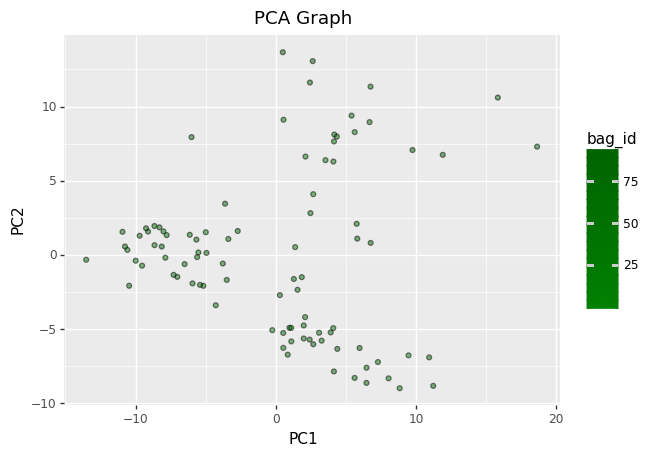

<ggplot: (-9223371939546510844)>

In [106]:
# PCA

pca = PCA(n_components = 2) # n_components specifies the new dimensionality
# Fit and transform PCA algorithm with features
X_reduced = pca.fit_transform(X)
# After dimensionality reduction we have 2 new components that are the two main dimensions of variation.(PC1,PC2)
X_reduced = pd.DataFrame( data = X_reduced, columns = ["PC1","PC2"])

# Concatenate bag_id and reduced features so that we can visualize our PCA plot colored by bag_id
musk_df_5 = pd.concat([X_reduced,(musk_4["bag_id"])],axis = 1)


# Plotting with ggplot

ggplot(
    musk_df_5) + geom_point(aes(x = 'PC1',y = 'PC2',fill = 'bag_id'),alpha = 0.5) +labs(
        title ='PCA Graph',
        x = 'PC1',
        y = 'PC2',) +scale_fill_gradient(low="green",high="darkgreen") 

Using median gives a pretty similar graph to mean's. 

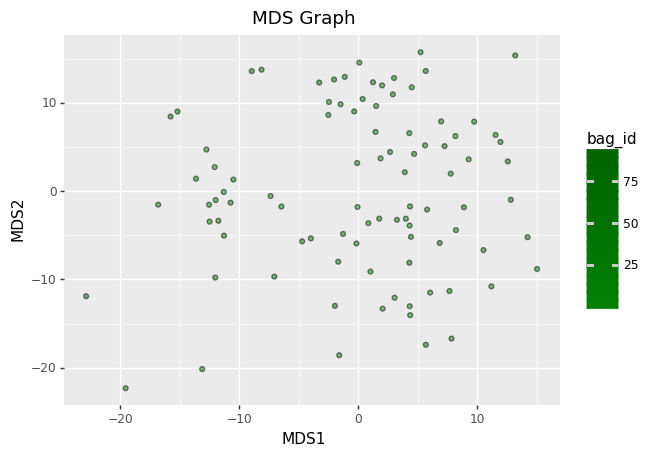

<ggplot: (-9223371939546461604)>

In [107]:
# MDS


standard = StandardScaler()
# separating our dataset into features and a target column(X,y)
X = (musk_4.drop(["bag_class","bag_id"], axis = 1))
# apply StandardScaler to X
X = standard.fit_transform(X)
# turn X into a dataframe
X = pd.DataFrame(X)
# define target variable y
y = (musk_4["bag_id"])

mds = MDS(n_components=2,random_state = 42)
X_transformed = mds.fit_transform(X)

X_transformed = pd.DataFrame(X_transformed, columns = ["MDS1","MDS2"])
musk_df_6 = pd.concat([X_transformed,musk_4["bag_id"]],axis = 1)



ggplot(
    musk_df_6) + geom_point(aes(x = 'MDS1',y = 'MDS2',fill = 'bag_id'),alpha = 0.5) +labs(
        title ='MDS Graph',
        x = 'MDS1',
        y = 'MDS2',) +scale_fill_gradient(low="green",high="darkgreen") 

Similar result to MDS plot after taking averages grouped by bag_id

# Task 2:Compress Images Using PCA

**Save an image as *.jpg or *.jpeg file**

In [108]:
from PIL import Image #PIL provides general image handling
import os
from pylab import * # to display images
import pandas as pd
import numpy as np
from skimage import color
from skimage import io
from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA

In [109]:
# Convert *.png image to *.jpg format

outfile = os.path.splitext("582\\HW2\\cat.png")[0] + ".jpg"
Image.open("582\\HW2\\cat.png").save(outfile)

**Resize the image to size 256x256 px (pixel)**

In [110]:
img = (Image.open("582\\HW2\\cat.jpg"))

In [111]:
# Resize the image to size 256x256 px (pixel)
img = img.resize((256,256))

In [112]:
# Display image size
img.size

(256, 256)

**1- Read the image and display it.**

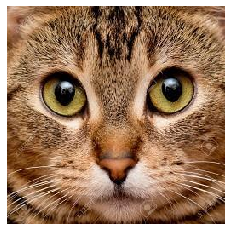

In [113]:
# Read image to array
img = array(Image.open("582\\HW2\\cat.jpg"))
# Display image
plt.imshow(img)
# to remove coordinate axis
axis("off");

**2- In order to create a noisy image, add a random noise from uniform distribution between min pixel
value and 0.1 times the maximum pixel value to each pixel for each channel of original image.**

We can use numpy's **np.random.uniform** function to add a random noise from uniform distribution

What we want to do : numpy.random.uniform(min pixel value, 0.1 times maximum pixel value, size of the matrix/image)

In [114]:
# Let's examine the shape of our image
img.shape

(256, 256, 3)

We have 3 channels: Red, Blue and Green in a 256x256 array before adding noise we need to split our image into 3 channels

In [115]:
# Slice image into red, green and blue channels

# Red Channel
image_R = img[:,:,0]

#Green Channel
image_G = img[:,:,1]

#Green Channel
image_B = img[:,:,2]

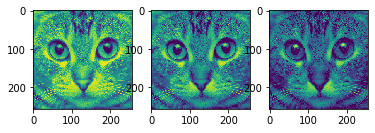

In [116]:
# Let's plot these 3 channels side by side

f, axarr = plt.subplots(1,3)
axarr[0].imshow(image_R)
axarr[1].imshow(image_G)
axarr[2].imshow(image_B)

In [117]:
# See the shape of channels
print("Channel Red Shape:{}\nChannel Green Shape:{}\nChannel Blue Shape: {}".format(image_R.shape,image_G.shape,image_B.shape))

Channel Red Shape:(256, 256)
Channel Green Shape:(256, 256)
Channel Blue Shape: (256, 256)


Get maximum and minimum pixel values for each channel

In [118]:
# Red Channel
R_min = image_R.min()
R_max = image_R.max()

# Green Channel
G_min = image_G.min()
G_max = image_G.max()

# Blue Channel
B_min = image_B.min()
B_max = image_B.max()

Create random noise from uniform distribution between min pixel value and 0.1 times the maximum pixel value to each pixel for each channel of original image

In [119]:
# create random noise for each channel and add the noise to the channel

# Red Channel
noise_R = np.random.uniform(R_min,R_max*0.1, image_R.size)
# reshape
noise_R.shape = (256,256)
# Add noise the to the image
image_Rn = noise_R + image_R

#Green Channel
noise_G = np.random.uniform(G_min,G_max*0.1, image_G.size)
# reshape
noise_G.shape = (256,256)
# Add noise the to the image
image_Gn = noise_G + image_G

# Blue Channel
noise_B = np.random.uniform(B_min, B_max*0.1, image_B.size)
# reshape
noise_B.shape = (256,256)
# Add noise the to the image
image_Bn = noise_B + image_B

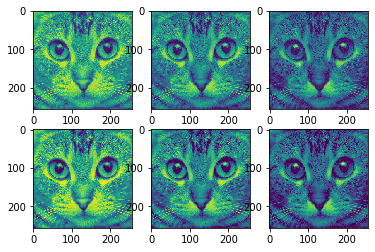

In [120]:
# Let's plot these 3 noisy channels and 3 original channels together
# first row denotes noisy images
# second row denotes original images

f, axarr = plt.subplots(2,3)
axarr[0,0].imshow(image_Rn)
axarr[0,1].imshow(image_Gn)
axarr[0,2].imshow(image_Bn)
axarr[1,0].imshow(image_R)
axarr[1,1].imshow(image_G)
axarr[1,2].imshow(image_B)

Reconstructing original image from the noisy channels

In [121]:
# Create an empty image with 3 channels

noisy_image = np.zeros((img.shape[0], img.shape[1], 3), dtype = int)

# Add channels one by one to the empty image

#Red Channel
noisy_image[:,:,0] = image_Rn

#Green Channel
noisy_image[:,:,1] = image_Gn

#Blue Channel
noisy_image[:,:,2] = image_Bn

**a. Display the new image.**

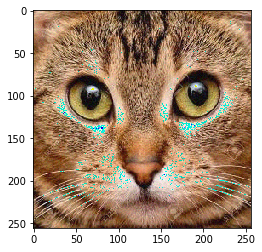

In [122]:
# Let's display the noisy image
plt.imshow(noisy_image.astype(np.uint8))

**b. Display each channel separately on a single plot.**

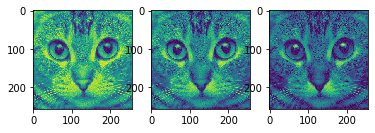

In [123]:
# split R,G,B channels
R = noisy_image[:,:,0]
G = noisy_image[:,:,1]
B = noisy_image[:,:,2]

# Display each channel on a single plot
f, axarr = plt.subplots(1,3)
axarr[0].imshow(R)
axarr[1].imshow(G)
axarr[2].imshow(B)

**3- Transform your noisy image to a greyscale**

In [124]:
grayscale_image = color.rgb2gray(noisy_image)

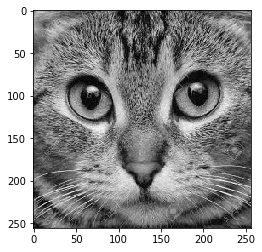

In [125]:
# Display grayscale image
imshow(grayscale_image,"gray")

**a) Apply PCA to this data matrix and comment on PCA results.**

In [126]:
# Extract patches from the image with size 25 by 25
patches = image.extract_patches_2d(grayscale_image, (25, 25), random_state = 42)
# reshape patches because scikit-learn expects 2d num arrays for the training dataset for a fit_transform function
# It's needed to pass an array of size (n_samples, n_features)
patches_reshaped = patches.reshape(patches.shape[0],-1)
# Print patches_reshaped shape
print("patches_reshaped shape:{}".format(patches_reshaped.shape))

patches_reshaped shape:(53824, 625)


We can see there are 53824 patches formed with each patch being represented by a feature vector of length 625

How PCA will view the data is as n_samples = 53824 and n_features = 625

As if we have a dataframe with 53824 rows and 625 feature columns

PCA

In [127]:
# Implement PCA
pca = PCA(n_components = 3,random_state = 42)
# Fit the model with patches_reshaped
pca_fit = pca.fit(patches_reshaped)

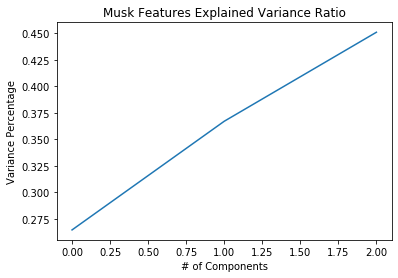

In [128]:
#Plotting the Cumulative Summation of the Explained Variance Ratio
# This helps us see how much of the total variance is covered with each principal component cumulatively
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('# of Components')
plt.ylabel('Variance Percentage') #for each component
plt.title('Musk Features Explained Variance Ratio')
plt.show()

Explained Variance

In [129]:
# The amount of variance explained by each of the selected components
explained_variance = pca_fit.explained_variance_
print("Explained Variance Ratio:" ,explained_variance)

Explained Variance Ratio: [1.05094317e-13 4.07420143e-14 3.33762086e-14]


Explained Variance Ratio

In [130]:
# Let's print the percentage of variance each component explains
#the ratio between the variance of that principal component and the total variance
explained_variance_ratio = ((pca_fit.explained_variance_ratio_)*100).tolist() 
# Add percentage sign to each item in the list
explained_variance_ratio = ["%" + str(round(ratio,2)) for ratio in explained_variance_ratio]
print("Explained Variance Ratio:" ,explained_variance_ratio)

Explained Variance Ratio: ['%26.45', '%10.25', '%8.4']


Explained Variance Ratio gives percentage of variance explained by each of the selected components

By the results, we can see that the first principal component contains 26.49% of the variance and the second principal component and the third principal component contain 10.27% and 8.42% respectively of the variance

Together the three components contain 45.18% of the information.

First 3 principal components

In [131]:
# Attributing first 3 components to variables
first_component = pca.components_[0] 
second_component = pca.components_[1]
third_component = pca.components_[2]

In [132]:
first_component

array([0.02401318, 0.02561327, 0.02715492, 0.02861105, 0.02996066,
       0.03118405, 0.03226727, 0.03319609, 0.03396589, 0.03458094,
       0.03502935, 0.03531035, 0.03542143, 0.03536908, 0.03515521,
       0.03477641, 0.0342171 , 0.03349469, 0.03263925, 0.03163436,
       0.03046076, 0.02915347, 0.02772379, 0.02619594, 0.02460255,
       0.02520797, 0.0269566 , 0.02863951, 0.03022841, 0.03169882,
       0.03303012, 0.03420764, 0.03521872, 0.03605338, 0.03671573,
       0.03719722, 0.03749368, 0.03760656, 0.03753878, 0.03729371,
       0.036869  , 0.03624925, 0.03545258, 0.03450696, 0.03339951,
       0.03211314, 0.03068345, 0.0291269 , 0.02746583, 0.02573107,
       0.0263409 , 0.02822924, 0.03004781, 0.03176287, 0.03335135,
       0.03479268, 0.03606247, 0.03714969, 0.03805184, 0.03876341,
       0.03927745, 0.03959113, 0.03970435, 0.03962232, 0.0393519 ,
       0.03888559, 0.03820648, 0.03733599, 0.03630321, 0.03509677,
       0.03370244, 0.03215655, 0.03047334, 0.02867755, 0.02680

**b) Reconstruct image from first,second and third components**

In [133]:
# Apply the dimensionality reduction on patches_reshaped
# Our image is projected into a subspace with 3 dimensions by calling the transform() function

pca_transformed = pca.fit_transform(patches_reshaped)

In [134]:
# Shape of pca_transformed
pca_transformed.shape

(53824, 3)

We have selected components in 3 directions with highest variance that in total explains %45.18 of the total variance in our data

**First Component**

In [135]:
# Reshape First Component--The new shape should be compatible with the original shape
first_component_reshaped = first_component.reshape(1,-1) 

In [136]:
first_component_reshaped.shape

(1, 625)

In [137]:
# get the first projection 
first_projection = pca_transformed[:,0]

In [138]:
# Make sure your first component is a column vector
first_projection = first_projection.reshape(-1,1)

In [139]:
# take the dot product of the projected data into the new subspace with new dimensions and our first component
# Add mean because input data is centered by default by our algorithm
inverse_transform_first = np.dot(first_projection, first_component_reshaped) + pca.mean_

In [140]:
# Reconstruct image from first component

first_component_image = image.reconstruct_from_patches_2d(inverse_transform_first.reshape(53824,25,25), grayscale_image.shape)

(256, 256)


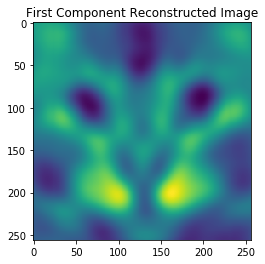

In [141]:
# Display first_component_image
imshow(first_component_image)
plt.title("First Component Reconstructed Image")
print(first_component_image.shape)

Since component 1 only represented %26.44 of the total variance the image above does not really describe our original image as a whole. Face shape if prominent for this component since it is expected that this components spans the highest variance and the face covers the majority of this picture.

Let's repeat the above steps for the second and third components

**Second Component**

Text(0.5, 1.0, 'Second Component Reconstructed Image')

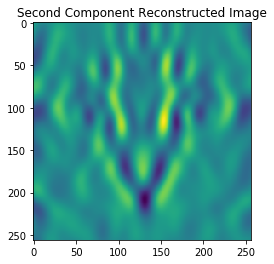

In [142]:
# Reshape Second Component--The new shape should be compatible with the original shape
#turn second component into a row vector
second_component_reshaped = second_component.reshape(1,-1) 

# get the second projection 
second_projection = pca_transformed[:,1]

# Make sure your second component is a column vector
second_projection = second_projection.reshape(-1,1)

# inverse transform
# Add mean because input data is centered by default by our algorithm
inverse_transform_second = np.dot(second_projection, second_component_reshaped) + pca.mean_

# Reconstruct image from second component

second_component_image = image.reconstruct_from_patches_2d(inverse_transform_second.reshape(53824,25,25), grayscale_image.shape)

# Display second_component_image
imshow(second_component_image)
plt.title("Second Component Reconstructed Image")

Component 2 represens %10.26 of the total variance. This component denotes the direction with the second highest variance. The facial features of the cat is less distinguishable compared to first component. Also, unlike the first component reconstructed image here we see eyes and nose of the cat is more prominent

**Third Component**

Text(0.5, 1.0, 'Third Component Reconstructed Image')

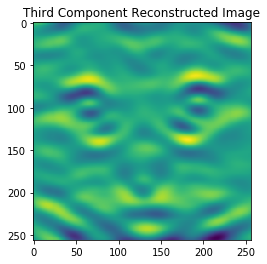

In [143]:
# Reshape Third Component--The new shape should be compatible with the original shape
third_component_reshaped = third_component.reshape(1,-1) 

# get the third projection 
third_projection = pca_transformed[:,2]

# Make sure your first component is a column vector
third_projection = third_projection.reshape(-1,1)

# inverse transform
# Add mean because input data is centered by default by our algorithm
inverse_transform_third = np.dot(third_projection, third_component_reshaped) + pca.mean_

# Reconstruct image from third component

third_component_image = image.reconstruct_from_patches_2d(inverse_transform_third.reshape(53824,25,25), grayscale_image.shape)

# Display third_component_image
imshow(third_component_image)
plt.title("Third Component Reconstructed Image")

Third component constitutes %8.43 of the total variance and pretty close to second component in terms of the variance ratio. There is not much difference compared to second component reconstructed image except that the color schemes are different and color details are less visible. Mouth is visible here differing from second components.

**c) Plot the first component as 25 by 25
image. Do the same for the second and third components and comment**


**We will apply the same steps as above except sizing**<br>
1.Turn eigenvector into row vector by reshaping(transpose it)<br>
2.get the projection of the data in the axis of our eigenvector then turn it into column vector(again transpose it)<br>
3.Take the dot product of transposed eigenvector and the transposed projection add mean<br>
4.Reconstruct image as 25 by 25 image

**First Component**

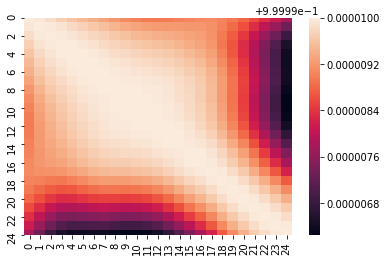

In [174]:
# Reshape First Component--The new shape should be compatible with the original shape
first_component_reshaped = first_component.reshape(1,-1)

# get the first projection 
first_projection = pca_transformed[:,0]

# Make sure your first component is a column vector
first_projection = first_projection.reshape(-1,1)

# take the dot product of the projected data into the new subspace with new dimensions and our first component
# Add mean because input data is centered by default by our algorithm
inverse_transform_first = np.dot(first_projection, first_component_reshaped) + pca.mean_

# Reconstruct image from first component as 25 by 25 image
first_component_image = image.reconstruct_from_patches_2d(inverse_transform_first.reshape(53824,25,25), (25,25))

# Convert image to dataframe find correlations and plot a heatmap

first_component_image = pd.DataFrame(first_component_image)
firstcorrelation = first_component_image.corr()
sns.heatmap(firstcorrelation)

**Second Component**

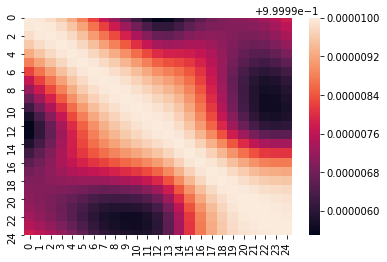

In [169]:
# Reshape Second Component--The new shape should be compatible with the original shape
#turn second component into a row vector
second_component_reshaped = second_component.reshape(1,-1) 

# get the second projection 
second_projection = pca_transformed[:,1]

# Make sure your second component is a column vector
second_projection = second_projection.reshape(-1,1)

# inverse transform
# Add mean because input data is centered by default by our algorithm
inverse_transform_second = np.dot(second_projection, second_component_reshaped) + pca.mean_

# Reconstruct image from second component as 25 by 25 image

second_component_image = image.reconstruct_from_patches_2d(inverse_transform_second.reshape(53824,25,25), (25,25))

# Convert image to dataframe find correlations and plot a heatmap

second_component_image = pd.DataFrame(second_component_image)
secondcorrelation = second_component_image.corr()
sns.heatmap(secondcorrelation)

**Third Component**

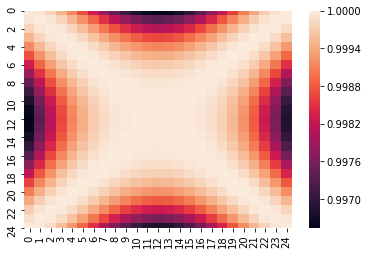

In [175]:
# Reshape Third Component--The new shape should be compatible with the original shape
third_component_reshaped = third_component.reshape(1,-1) 

# get the third projection 
third_projection = pca_transformed[:,2]

# Make sure your first component is a column vector
third_projection = third_projection.reshape(-1,1)

# inverse transform
# Add mean because input data is centered by default by our algorithm
inverse_transform_third = np.dot(third_projection, third_component_reshaped) + pca.mean_

# Reconstruct image from third component as 25 by 25 image

third_component_image = image.reconstruct_from_patches_2d(inverse_transform_third.reshape(53824,25,25), (25,25))
# Convert image to dataframe find correlations and plot a heatmap
third_component_image = pd.DataFrame(third_component_image)
thirdcorrelation = third_component_image.corr()
sns.heatmap(thirdcorrelation)

First image displays a correlation based around the overall area of the image. <br>Second component displays variance on a smaller area.<br>Third component seems to be more correlated however,this method shows the correlations for each component itself so not a very good way to compare between components. But in one component's entirety we can see in which areas integrity of the image preserved.